In [2]:
import numpy as np
import random
import gym_graph
import gym
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline

In [3]:
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from keras.optimizers import Adam
import keras.backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
WINDOW_LENGTH = 12

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
env = gym.make("simple-static-graph-v0")
# np.random.seed(123)
# env.seed(123)
nb_actions = env.action_space.n

imported libraries
/Users/scottfarley/Documents/rl-graph/gym_graph/envs /Users/scottfarley/Documents/rl-graph/gym_graph/envs/simpleWorld.gpickle
/Users/scottfarley/Documents/rl-graph/gym_graph/envs /Users/scottfarley/Documents/rl-graph/gym_graph/envs/simpleWorld.gpickle
Navigation Environment - /Users/scottfarley/Documents/rl-graph/gym_graph/envs/simpleWorld.gpickle - Version 0.1.0
/Users/scottfarley/Documents/rl-graph/gym_graph/envs/simpleWorld.gpickle


<Figure size 432x288 with 0 Axes>

Environment reset for episode  0
I'm facing:  90
[200.61657653685074, 93.89980781536656]
initially facing:  90
I'm facing:  90
[200.61657653685074, 93.89980781536656]
[90, 0, 0.0, 0, 0.006179700000004118, 2, -1, -1, -1, -181, -1, -1, -1, -181, -1, -1, -1, -181, 105.101, 25, 0.017058175047177614, 200.61657653685074, -1, -1, -1, -181, -1, -1, -1, -181, 292.653, 50, 0.03195933976634626, 93.89980781536656, -1, -1, -1, -181]
render facing:  90
I'm facing:  90
[200.61657653685074, 93.89980781536656]


[{'destination': None, 'angle': None, 'action': 'STRAIGHT'},
 {'destination': None, 'angle': None, 'action': 'SLIGHT_LEFT'},
 {'destination': None, 'angle': None, 'action': 'LEFT'},
 {'destination': 276546821,
  'angle': 200.61657653685074,
  'action': 'HARD_LEFT'},
 {'destination': None, 'angle': None, 'action': 'U-TURN'},
 {'destination': None, 'angle': None, 'action': 'HARD_RIGHT'},
 {'destination': 5352470014, 'angle': 93.89980781536656, 'action': 'RIGHT'},
 {'destination': None, 'angle': None, 'action': 'SLIGHT_RIGHT'}]

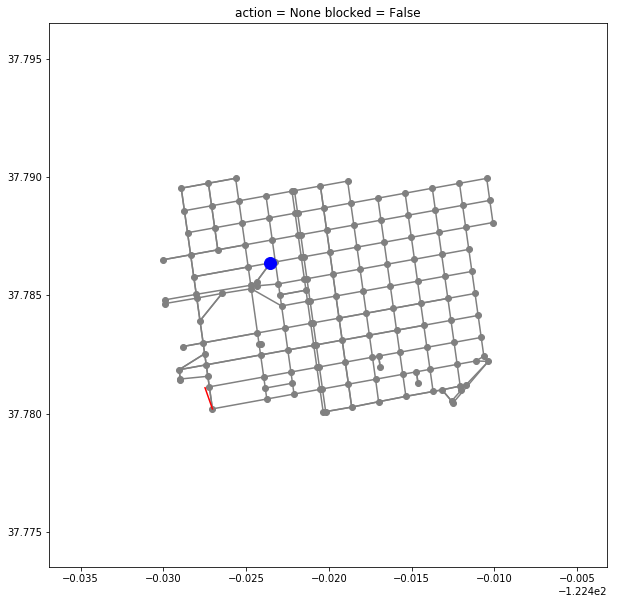

In [5]:
initObs = env.reset()
print (initObs)
env.render()
# # env.render()
# # print(env.getActions())
# env.step(0)

# env.render()
env.getActions()

I'm facing:  90
[200.61657653685074, 93.89980781536656]
curringly facing:  90
going to travel:  None
I'm facing:  90
[200.61657653685074, 93.89980781536656]
I'm facing:  90
[200.61657653685074, 93.89980781536656]
[{'action': 'STRAIGHT', 'angle': None, 'destination': None},
 {'action': 'SLIGHT_LEFT', 'angle': None, 'destination': None},
 {'action': 'LEFT', 'angle': None, 'destination': None},
 {'action': 'HARD_LEFT', 'angle': 200.61657653685074, 'destination': 276546821},
 {'action': 'U-TURN', 'angle': None, 'destination': None},
 {'action': 'HARD_RIGHT', 'angle': None, 'destination': None},
 {'action': 'RIGHT', 'angle': 93.89980781536656, 'destination': 5352470014},
 {'action': 'SLIGHT_RIGHT', 'angle': None, 'destination': None}]
render facing:  90


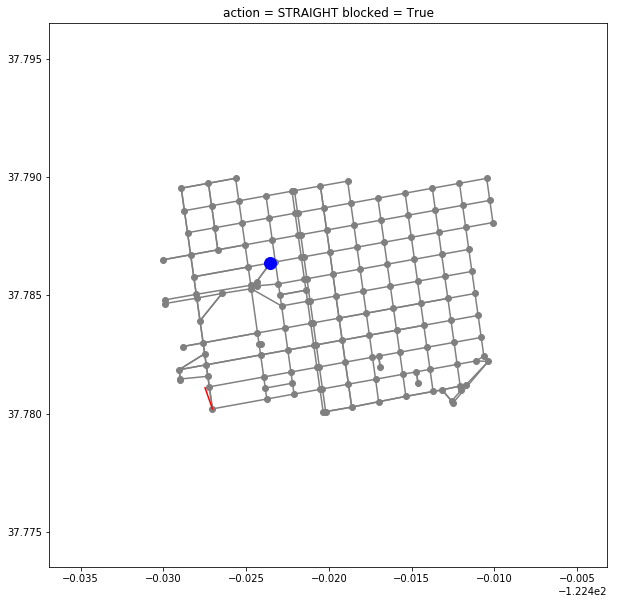

In [6]:
import pprint as _p
env.step(0)
_p.pprint(env.getActions())
env.render()


In [6]:

class EnvProcessor(Processor):
    def process_observation(self, observation):
        print (observation)
        return observation

    def process_reward(self, reward):
        print (reward)
        return reward

In [6]:
INPUT_SHAPE = (len(initObs),)
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(1024))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions, activation="softmax"))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 456)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              467968    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 3591      
Total params: 996,359
Trainable params: 996,359
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
processor = EnvProcessor()

In [8]:
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.05, value_test=.05,
                              nb_steps=200000)

# The trade-off between exploration and exploitation is difficult and an on-going research topic.
# If you want, you can experiment with the parameters or use a different policy. Another popular one
# is Boltzmann-style exploration:
# policy = BoltzmannQPolicy(tau=1.)
# Feel free to give it a try!

dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               nb_steps_warmup=10000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)
dqn.compile(Adam(lr=.00025), metrics=['mae'])


Training for 1 steps ...
Environment reset for episode  1
[249.4, 356.1]
[249.4, 356.1]
[249.4, 356.1]
[249.4, 356.1]
done, took 0.428 seconds


KeyboardInterrupt: 

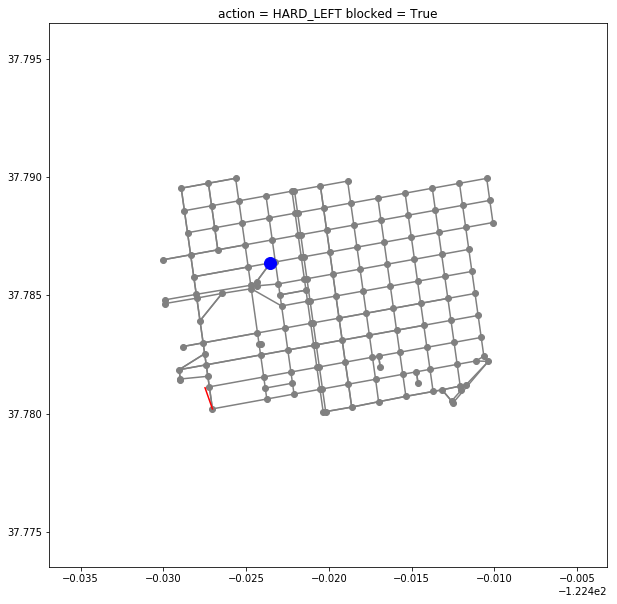

In [9]:

# Okay, now it's time to learn something! We capture the interrupt exception so that training
# can be prematurely aborted. Notice that you can the built-in Keras callbacks!
weights_filename = 'dqn_{}_weights.h5f'.format("graph-v0")
checkpoint_weights_filename = 'dqn_graph-v0_weights_{step}.h5f'
log_filename = 'dqn_{}_log.json'.format("graph-v0")
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000)]
callbacks += [FileLogger(log_filename, interval=100)]
dqn.fit(env, callbacks=callbacks, nb_steps=1, log_interval=10000, verbose=2, visualize=True)

# After training is done, we save the final weights one more time.
dqn.save_weights(weights_filename, overwrite=True)

# Finally, evaluate our algorithm for 10 episodes.
dqn.test(env, nb_episodes=10, visualize=True)

In [ ]:
plt.show()

In [ ]:
fig, ax = plt.figure()
ax.plot